In [428]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cdist
from scipy.special import expit

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw


In [429]:
#create a grid of the correct size:
grid_size = 100
a,b = np.ones([grid_size, grid_size]).nonzero()
gPoints = np.vstack([a,b]).T
print(gPoints.shape)

(10000, 2)


In [430]:
centres = np.array([[45,50], [25,25]])
radii = np.array([20,20])

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


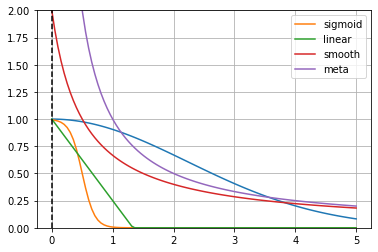

In [431]:
#do some function to 'm' that weights between distances. 
def squared_exponential(distance):
    return np.exp(distance**2/ -10)

def sigmoid(x):
    return 1*(1-expit(x*10-5))
    return 0.2*(1-expit(x*0.8-5)) #worked okay but weighting function is wrong.

    #return (1-expit(x*3-2))
    

def lin(x):
    return np.clip(1-0.75*x, 0, 1)

def metaball(x):
    return 1 / (x)

def smooth(x):
    return 1/((x+0.5))
    return 1/(2*(x+0.5)) #this was the best one so far

x = np.linspace(0,5, 100)
plt.plot(x, squared_exponential(x))
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, lin(x), label='linear')
plt.plot(x, smooth(x), label='smooth')
plt.plot(x, metaball(x), label='meta')
plt.ylim(0,2)
plt.axvline(0, c='k', linestyle='--')
plt.grid()
plt.legend()

In [432]:
##Get the distances from every graph point (rows) to every atom centre (columns)
distances =cdist(gPoints, centres)

In [433]:
#Find the atom indices of the nearest distance to an atom surface:
argpart = np.argpartition(distances-radii, 1, axis=1)
#argpart = np.argpartition(distances/radii, 1, axis=1)
one_nn = argpart[:,0]
long_radii = radii[one_nn]

In [434]:
#how close is each grid point to each atom:
to_atom_distance = distances-radii
k = sigmoid(to_atom_distance)
#k = lin(to_atom_distance)
#k = metaball(distances/20)
k = smooth(to_atom_distance)
#
##ensure that the radius to the nearest atom is has a kernel of 1. 
k[np.arange(k.shape[0]), one_nn]=1

In [435]:
##Take only the distance to the nearest atom:
nearest_distances = distances[np.arange(one_nn.shape[0]), one_nn]


In [436]:
val = (nearest_distances-long_radii*k.sum(1))#*k.sum(1)
#val = (metaball((distances/20)**2).sum(1))

In [437]:
grid = np.zeros([grid_size, grid_size])
#grid[gPoints[:,0], gPoints[:,1]]=(distances -radii*k).min(1)
grid[gPoints[:,0], gPoints[:,1]]=val#nearest_distances-long_radii#(distances-val).min(1)

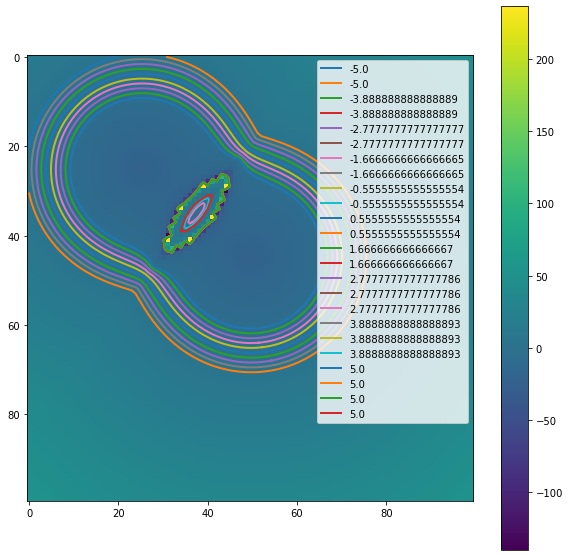

In [438]:
from skimage import measure

plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.colorbar()


for cutoff in np.linspace(-5,5,10):
    contours = measure.find_contours(grid,cutoff)
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, label=cutoff)
plt.legend()
    
# contours = measure.find_contours(grid,0)
# for n, contour in enumerate(contours):
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='orange')
    
# contours = measure.find_contours(grid,-2)
# for n, contour in enumerate(contours):
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='pink')

In [439]:
#create a grid of the correct size:
grid_size = 60
a,b,c = np.ones([grid_size, grid_size, grid_size]).nonzero()
gPoints = np.vstack([a,b,c]).T

atom_centres = np.random.uniform(20,40, (40,3))
radii = np.ones(40)*3

In [440]:
##Get the distances from every graph point (rows) to every atom centre (columns)
distances =cdist(gPoints, atom_centres)

In [441]:
#Find the atom indices of the nearest distance to an atom surface:
argpart = np.argpartition(distances-radii, 1, axis=1)
#argpart = np.argpartition(distances/radii, 1, axis=1)
one_nn = argpart[:,0]
long_radii = radii[one_nn]

In [442]:
#how close is each grid point to each atom:
to_atom_distance = distances-radii
k = sigmoid(to_atom_distance)
#k = lin(to_atom_distance)
#k = metaball(distances/20)
k = smooth(to_atom_distance)
#
##ensure that the radius to the nearest atom is has a kernel of 1. 
k[np.arange(k.shape[0]), one_nn]=1

In [443]:
##Take only the distance to the nearest atom:
nearest_distances = distances[np.arange(one_nn.shape[0]), one_nn]
val = (nearest_distances-long_radii*k.sum(1))

In [444]:
grid = np.zeros([grid_size, grid_size,grid_size])
grid[gPoints[:,0], gPoints[:,1], gPoints[:,2]]=val


In [445]:
from skimage import measure
import fresnel
import igl


In [446]:
import igl
lv, lf = igl.loop(vert, faces)
#lv, lf = igl.loop(lv, lf)

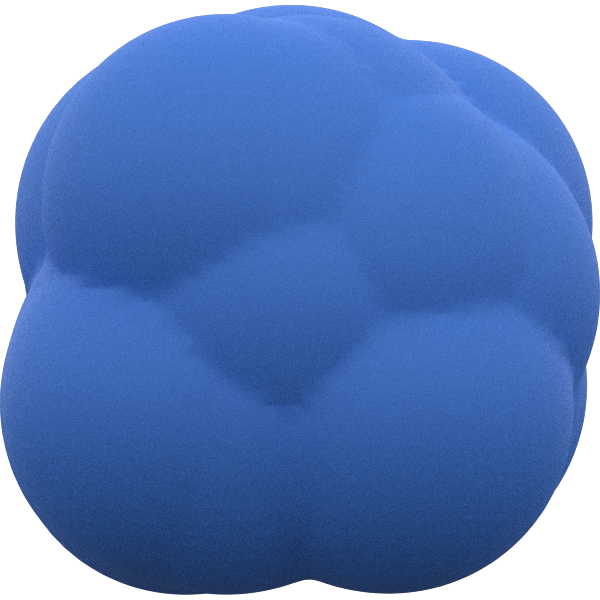

In [447]:
##With a grid of five:
vert, faces, norm, values = measure.marching_cubes_lewiner(grid,5)
lv, lf = igl.loop(vert, faces)
lv, lf = igl.loop(lv, lf)
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=lv[lf].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=80, h=600, w=600)

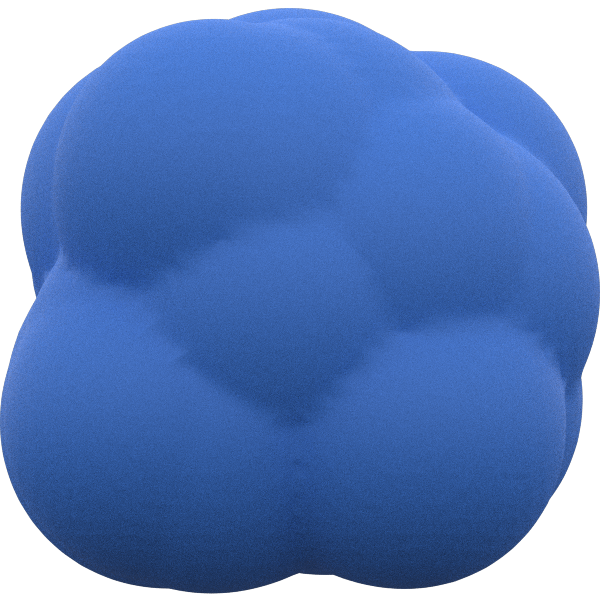

In [448]:
##With a grid of five:
vert, faces, norm, values = measure.marching_cubes_lewiner(grid,0)
lv, lf = igl.loop(vert, faces)
lv, lf = igl.loop(lv, lf)
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=lv[lf].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=80, h=600, w=600)

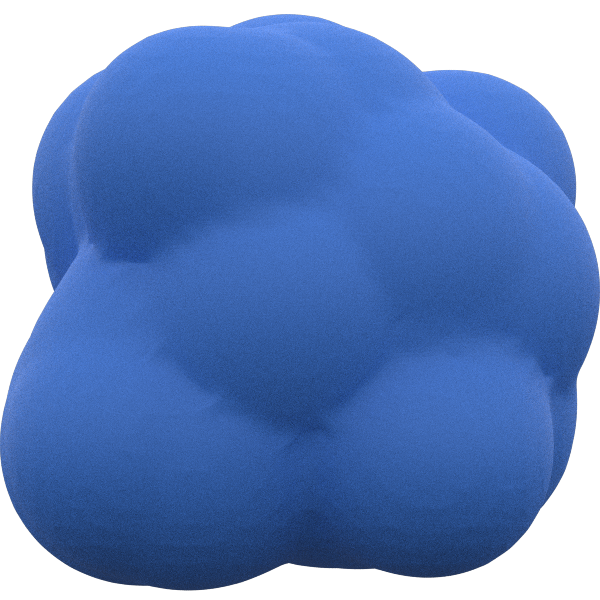

In [449]:
##With a grid of five:
vert, faces, norm, values = measure.marching_cubes_lewiner(grid,-5)
lv, lf = igl.loop(vert, faces)
lv, lf = igl.loop(lv, lf)
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=lv[lf].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=80, h=600, w=600)

In [450]:
mol = Chem.MolFromSmiles('CCCCCC1=CC(=C2C3C=C(CCC3C(OC2=C1)(C)C)C)O')
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
conf = mol.GetConformer()
positions = np.array([list(conf.GetAtomPosition(int(i))) for i in range(mol.GetNumAtoms())])
positions = (positions - np.mean(positions,0)) + 10
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.GetAtoms()])
radii = radii-0.2

In [451]:


atom_centres = positions.copy()
atom_centres -= np.min(atom_centres,0)


proberadius=1.4
molecule_volume = np.max(atom_centres) #in angstroms
grid_spacing = 0.2
buffer = 5 #angstrom
grid_size = int(np.rint(molecule_volume / grid_spacing) + np.rint(2*buffer/grid_spacing))

proberadius = proberadius/grid_spacing
radii = radii/grid_spacing

In [452]:
#create a grid of the correct size:
a,b,c = np.ones([grid_size, grid_size, grid_size]).nonzero()
gPoints = np.vstack([a,b,c]).T
print(gPoints.shape)

(1771561, 3)


In [453]:
#Calculate the minimum distance to atom centres (after mapping to grid units)
distances =(cdist(gPoints, (atom_centres+buffer)/grid_spacing))

#Find the atom indices of the nearest distance to an atom surface:
argpart = np.argpartition(distances-radii+(buffer/grid_spacing), 1, axis=1)
#argpart = np.argpartition(distances/radii, 1, axis=1)
one_nn = argpart[:,0]
long_radii = radii[one_nn]


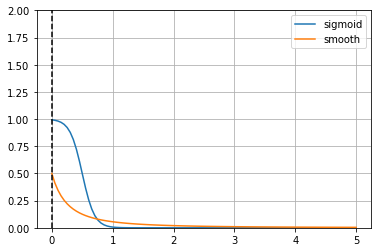

In [500]:
def smooth(x):
    return 0.125/(((x+0.5)**2))

x = np.linspace(0,5, 100)

plt.plot(x, sigmoid(x), label='sigmoid')

plt.plot(x, smooth(x), label='smooth')

plt.ylim(0,2)
plt.axvline(0, c='k', linestyle='--')
plt.grid()
plt.legend()

In [507]:
#how close is each grid point to each atom:


##I know this works:
to_atom_distance = distances- radii

##But shouldnt everything be in units of percentage radius? ie:
#to_atom_distance = distances/ radii

#k = sigmoid(to_atom_distance)
k = smooth(to_atom_distance*10)
#
##ensure that the radius to the nearest atom is has a kernel of 1. 
k[np.arange(k.shape[0]), one_nn]=1

In [508]:
##Take only the distance to the nearest atom:
nearest_distances = distances[np.arange(one_nn.shape[0]), one_nn]
val = (nearest_distances-long_radii*k.sum(1))

In [509]:
grid = np.zeros([grid_size, grid_size,grid_size])
grid[gPoints[:,0], gPoints[:,1], gPoints[:,2]]=val


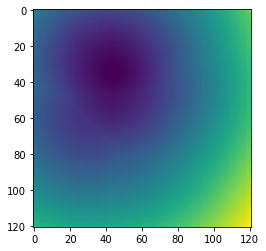

In [510]:
plt.imshow(grid[10])

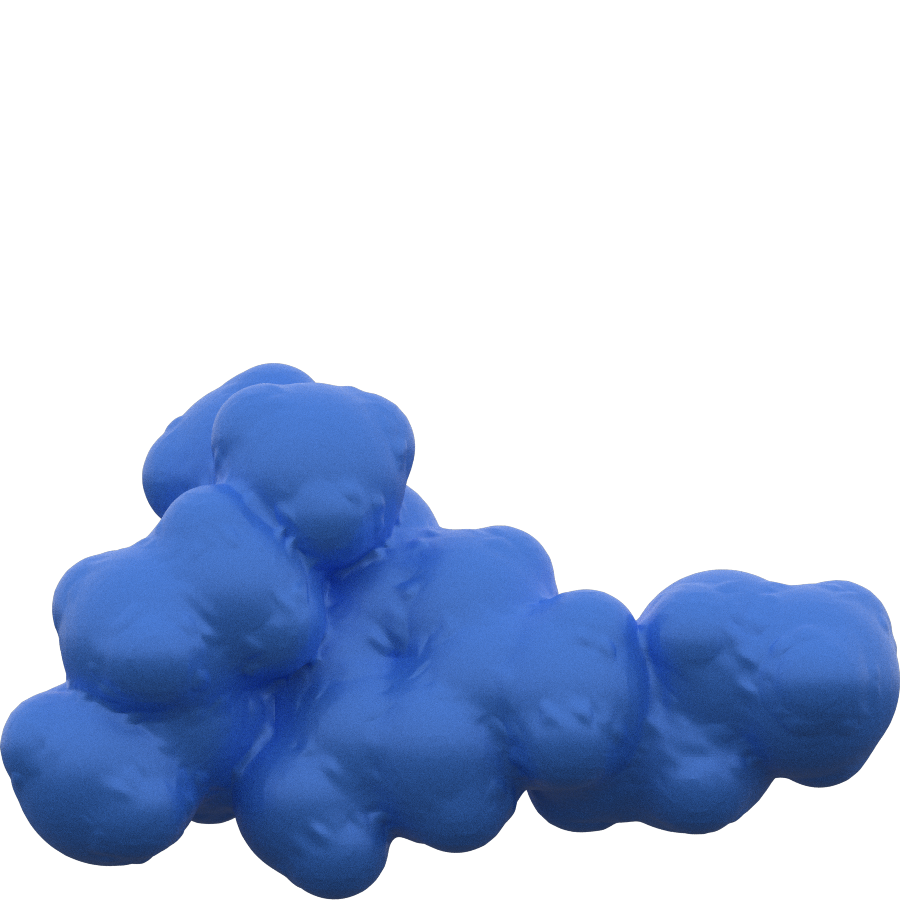

In [511]:
##With a grid of five:
vert, faces, norm, values = measure.marching_cubes_lewiner(grid,0)
lv = vert.copy()
lf = faces.copy()
lv, lf = igl.loop(vert, faces)
lv, lf = igl.loop(lv, lf)
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=lv[lf].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), 
                                          roughness=0.4, specular=0.6, metal=0.3)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=200, h=900, w=900)